<a href="https://colab.research.google.com/github/NeonRio/CaloriesBurnt_XGBoost/blob/main/CaloriesBurnt_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload your kaggle.json file into /content path.

Installing Kaggle on colab.

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=bd32d98e78db467ba3cf621c651d03275629e7d298f0de2a46070dac0baa86f2
  Stored in directory: /root/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Putting kaggle.json into right place and changing permissions of it.

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download the dataset.

In [3]:
!kaggle datasets download -d fmendes/fmendesdat263xdemos

  0% 0.00/296k [00:00<?, ?B/s]
100% 296k/296k [00:00<00:00, 68.9MB/s]


In [4]:
!unzip fmendesdat263xdemos.zip
!rm fmendesdat263xdemos.zip

Archive:  fmendesdat263xdemos.zip
  inflating: calories.csv            
  inflating: exercise.csv            


# Importing the dependencies

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

# Data Loading

Now we gonna to read our csv data via pandas

In [7]:
calories = pd.read_csv("calories.csv")
exercise = pd.read_csv("exercise.csv")

Let's print first 10 rows of each csv.

In [8]:
calories.head(10)

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0
5,15130815,123.0
6,19602372,112.0
7,11117088,143.0
8,12132339,134.0
9,17964668,72.0


In [9]:
exercise.head(10)

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8
5,15130815,female,36,151.0,50.0,23.0,96.0,40.7
6,19602372,female,33,158.0,56.0,22.0,95.0,40.5
7,11117088,male,41,175.0,85.0,25.0,100.0,40.7
8,12132339,male,60,186.0,94.0,21.0,97.0,40.4
9,17964668,female,26,146.0,51.0,16.0,90.0,40.2


Combining the two DataFrames

In [13]:
df = pd.concat([exercise, calories["Calories"]], axis=1)

In [14]:
df.head(10)

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0
5,15130815,female,36,151.0,50.0,23.0,96.0,40.7,123.0
6,19602372,female,33,158.0,56.0,22.0,95.0,40.5,112.0
7,11117088,male,41,175.0,85.0,25.0,100.0,40.7,143.0
8,12132339,male,60,186.0,94.0,21.0,97.0,40.4,134.0
9,17964668,female,26,146.0,51.0,16.0,90.0,40.2,72.0


# Data Analysis

In [15]:
df.shape

(15000, 9)

We can see that our DataFrame has 15000 rows and 9 columns.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


Checking for missing values

In [17]:
df.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

As we can see this is good dataset cause there are no missing (NaN) values in it.

Statistical measures about the data.

In [18]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


## Data Visualizing

In [21]:
sns.set()

Let's plot the distribution of each column

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


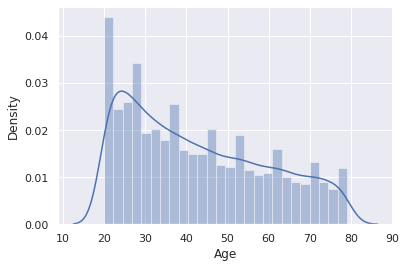

In [22]:
sns.distplot(df["Age"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


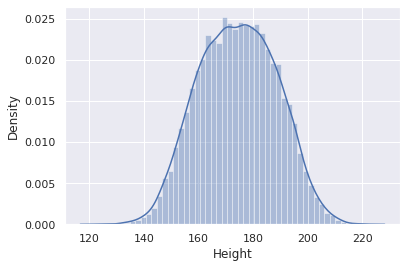

In [23]:
sns.distplot(df["Height"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


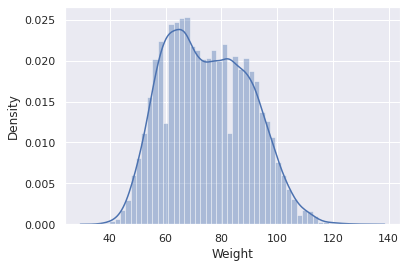

In [24]:
sns.distplot(df["Weight"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


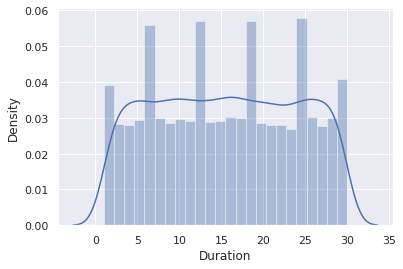

In [25]:
sns.distplot(df["Duration"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


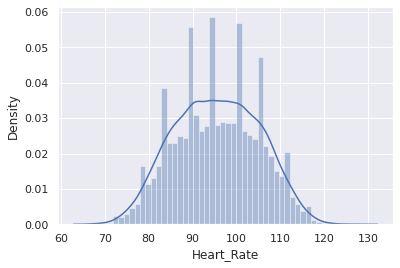

In [27]:
sns.distplot(df["Heart_Rate"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


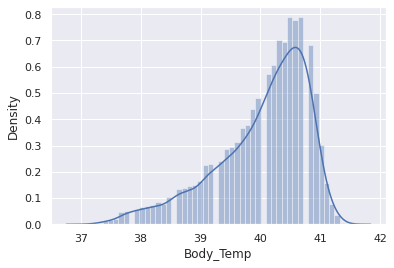

In [28]:
sns.distplot(df["Body_Temp"])

Exploring our dataset correlation.

In [29]:
correlation = df.corr()

In [30]:
correlation

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
User_ID,1.000000,-0.001827,-0.013520,-0.011603,-0.002751,-0.000457,0.000923,-0.001661
Age,-0.001827,1.000000,0.009554,0.090094,0.013247,0.010482,0.013175,0.154395
Height,-0.013520,0.009554,1.000000,0.958451,-0.004625,0.000528,0.001200,0.017537
Weight,-0.011603,0.090094,0.958451,1.000000,-0.001884,0.004311,0.004095,0.035481
Duration,-0.002751,0.013247,-0.004625,-0.001884,1.000000,0.852869,0.903167,0.955421
Heart_Rate,-0.000457,0.010482,0.000528,0.004311,0.852869,1.000000,0.771529,0.897882
Body_Temp,0.000923,0.013175,0.001200,0.004095,0.903167,0.771529,1.000000,0.824558
Calories,-0.001661,0.154395,0.017537,0.035481,0.955421,0.897882,0.824558,1.000000


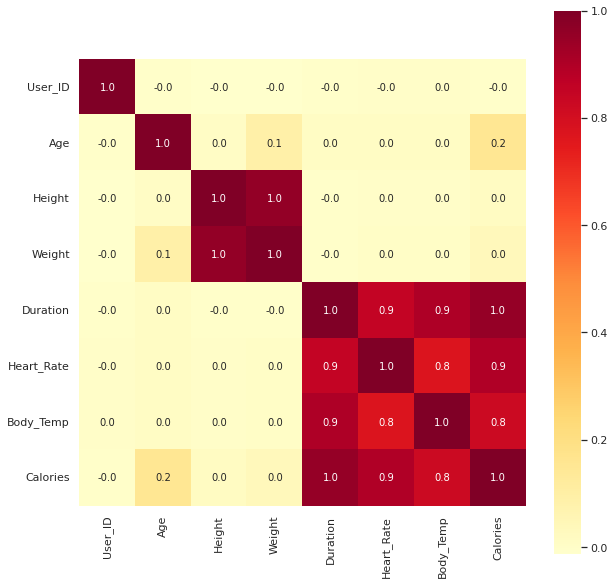

In [31]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={"size":10}, cmap="YlOrRd")

## Processing train and test data

To work with machine learning algorithms we need numeric data, but in our dataset gender column has non-numerical values ("Male", "Female"). We need to encode these values into numerical ones.

In [32]:
df.replace({"Gender":{"female":0,"male":1}}, inplace=True)

Let's check our dataframe.

In [33]:
df.head(10)

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,0,27,154.0,58.0,10.0,81.0,39.8,35.0
5,15130815,0,36,151.0,50.0,23.0,96.0,40.7,123.0
6,19602372,0,33,158.0,56.0,22.0,95.0,40.5,112.0
7,11117088,1,41,175.0,85.0,25.0,100.0,40.7,143.0
8,12132339,1,60,186.0,94.0,21.0,97.0,40.4,134.0
9,17964668,0,26,146.0,51.0,16.0,90.0,40.2,72.0


Now we have only numerical values in our dataframe.

Separating features and targets.

In [35]:
X = df.drop(["User_ID","Calories"], axis=1)
Y = df["Calories"]

In [36]:
print(X)
print(Y)

       Gender  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0           1   68   190.0    94.0      29.0       105.0       40.8
1           0   20   166.0    60.0      14.0        94.0       40.3
2           1   69   179.0    79.0       5.0        88.0       38.7
3           0   34   179.0    71.0      13.0       100.0       40.5
4           0   27   154.0    58.0      10.0        81.0       39.8
...       ...  ...     ...     ...       ...         ...        ...
14995       0   20   193.0    86.0      11.0        92.0       40.4
14996       0   27   165.0    65.0       6.0        85.0       39.2
14997       0   43   159.0    58.0      16.0        90.0       40.1
14998       1   78   193.0    97.0       2.0        84.0       38.3
14999       1   63   173.0    79.0      18.0        92.0       40.5

[15000 rows x 7 columns]
0        231.0
1         66.0
2         26.0
3         71.0
4         35.0
         ...  
14995     45.0
14996     23.0
14997     75.0
14998     11.0
14999   

Now let's split data into training data and test data.

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=74)

`test_size=0.2` means that 20% of our data we're going to use as test data, and 80% as train data.

In [39]:
X.shape, X_test.shape, X_train.shape

((15000, 7), (3000, 7), (12000, 7))

# XGBoost model

## Model initialization

In [40]:
model = XGBRegressor()

## Model training

In [41]:
model.fit(X_train, Y_train)

[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

## Model Evaluation

Now let's check our model on test data.

In [42]:
test_pred = model.predict(X_test)

In [43]:
print(test_pred)

[ 11.461712 141.19797   67.79494  ... 130.35342   19.179007  40.543156]


This is regression task which means that we can't use accuracy as our metrics, instead we will use R squared error and mean absolute error.

R squared error

In [45]:
score_r2 = metrics.r2_score(Y_test, test_pred)

Mean Absolute error

In [46]:
score_mean_absolute = metrics.mean_absolute_error(Y_test, test_pred)

In [47]:
print("R squared error: ", score_r2)
print("Mean Absolute error: ", score_mean_absolute)

R squared error:  0.9965870267779788
Mean Absolute error:  2.6623671726584432


As you can see we have pretty small error values which means that our model is performing really good.

## Visualizing our results.

Now I'm going to plot graph with Y_test and test_pred to see how close they are.

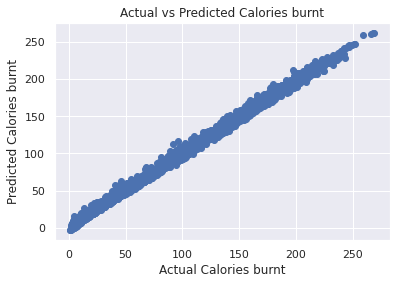

In [49]:
plt.scatter(Y_test, test_pred)
plt.xlabel("Actual Calories burnt")
plt.ylabel("Predicted Calories burnt")
plt.title("Actual vs Predicted Calories burnt")
plt.show()